In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.cluster import k_means, kmeans_plusplus, KMeans
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
# Some helper functions to plot from the book
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# Clustering Part 2

In addition to k-means, we can also take some different approaches to clustering. Just like different classification or regression algorithms can capture different relationships in data, different clustering algorithms can capture different patterns of similarity for grouping data. These other clustering algorithms are mostly very similar in terms of how we use them to the k-means clustering. We won't spend a lot of time invesstigating their details, but we should keep them in our toolkit if we are attempting to cluster data. 

## Agglomerative Clustering 

There are alternate ways to cluster data, one of them being agglomerative clustering (AC). AC works by starting with every data point in its own cluster, then merges those clusters together based on similarity until the specified number of clusters is reached. The similarity metric is defined in a paramater, linkage criteria:
<ul>
<li>Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
<li>Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
<li>Average linkage minimizes the average of the distances between all observations of pairs of clusters.
<li>Single linkage minimizes the distance between the closest observations of pairs of clusters.
</ul>

Similarly to how different kernels divided data differently with a SVM, each choice will deliver different results with different datasets. Ward, the default, tends to give clusters that are the most consistent in size; single linkage is fast, but tends to have the largest cluster(s) grow to dominate the others. 

![AC](images/ac.png "AC" )

In [3]:
#df_agg = pd.read_csv("data/diabetes.csv")
#y_agg = df_agg["Outcome"]
#X_agg = df_agg.drop(columns={"Outcome"})
df_agg = pd.read_csv("data/mtcars.csv")
y_agg = df_agg["mpg"]
X_agg = df_agg.drop(columns={"model", "mpg"})
X_agg.head()


,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,8,360.0,175,3.15,3.440,17.02,0,0,3,2


#### Visualize Agglomerative Clustering

We can visualize how agglomerative clustering works by using something called a dendrogram. This chart is kind of like a tree, at the bottom are all of the original clusters, starting with clusters of n = 1. As you move up the tree, those clusters are grouped into fewer and few clusters as they are merged together. 

In this small example of cars, down at the bottom each "column" is a different car, they are then grouped together round by round according to how similar they are. If the image/resolution is large enough on your monitor you can see the indexes of the rows along the x-axis, each one being a car from the dataset. 

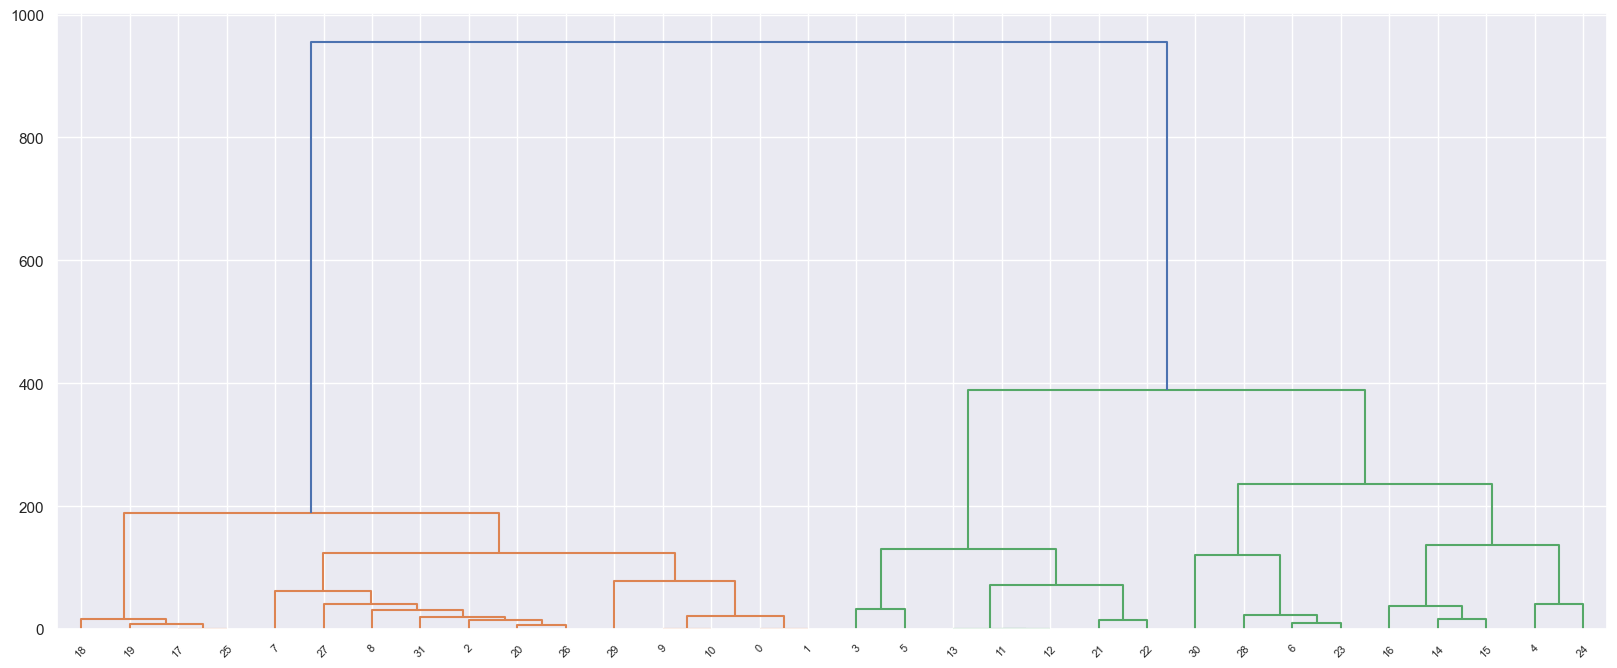

In [4]:
plt.rcParams["figure.figsize"] = (20,8)
dendrogram = sch.dendrogram(sch.linkage(X_agg, method='ward'))

#### How Many Clusters

The dendrogram can be used to estimate an optimal number of clusters, in a simple but odd way. Draw a horizontal line across the chart, and see how many lines it crosses. We can look for the longest vertical stretch where the number of lines crossed does not change. This is our suggestion of a good number of clusters. We can start here for the number of clusters. 

In [5]:
model_agg = AgglomerativeClustering(n_clusters=2, linkage='ward')
model_agg.fit(X_agg)
labels_agg = model_agg.labels_

In [6]:
tmp = pd.DataFrame(X_agg)
tmp["label"] = labels_agg
tmp["label"].value_counts().sort_index()

0    16
1    16
Name: label, dtype: int64

This method of clustering doesn't give centers like k-means, since it isn't based on the same logic - there isn't a middle like there is for k-means. 

### Unspecified Number of Clusters

Agglomerative clustering also works without specifying a number of clusters. It will follow the recursive process above, settling where your imaginary dendrogram line would be. Try this with a couple of different linkages, the results might vary a bit. 

In [7]:
model_agg2 = AgglomerativeClustering(linkage='single')
model_agg2.fit(X_agg)
labels_agg2 = model_agg2.labels_
tmp2 = pd.DataFrame(X_agg)
tmp2["label"] = labels_agg2
tmp2["label"].value_counts().sort_index()

0    31
1     1
Name: label, dtype: int64

## Clustering for Preprocessing

One neat trick that we can pull is to use clustering as a preperatory step for supervised learning algorithms. This is a two step process:
<ul>
<li> Use clustering to group data into clusters, the cluster labels become the new target variable. 
<li> The now labeled data (original features + cluster labels) can be used to train a classification model. 
</ul>

This approach can be useful when dealing with data that is large and unorganized, and exploring and understanding the data is part of what we need to do. Think about something like higly specific targeting of Facebook profiles for political ads. This is one thing that made up the Russian interference in the 2016 US election - they identified small groups of people that were likely to be swayed by specific messages, and targeted them. Identifiying these groups can be approached as a clustering problem, there is a large amount of data to possibly use (location, likes, age, interests, friends, etc...), but there isn't a clear indication on which of those features might be useful. The people could be grouped using all those features, and the most similar people would tend to be grouped together. Those groups could then be examined, combined, and labeled - the outcome of this feeding a classifier which can predict the group (and associated targeting strategy), for any new person. 

Since the classification model now has an input of all those personal features that were used to cluster, and a target of a group label, we could also use something like regularization to identify which feature are important. Our end result is a classification model that takes in a subset of the original features, and predicts how that person should be targeted. What we dreamed of from the start!

Something like this is also a good example of taking a flexible approach to solving a specific problem. There are many cases like this where we may have to deal with data that is messy and unorganized, or with scenarios where we aren't 100% what our features and targets look like from the start. This is especially true in some of the more common places where predicive models are used in the workplace, like marketing. In this election example we don't really start knowing how people will fall into groups, what those groups will be, or what determines which group a person will fall into. We can look for different approaches and tools to work in that direction though, which is what is here. The end result isn't "accurate" in the same way that a model built from a labeled dataset is, but in scenarios such as this, that's not bad. Identifying what interest group someone falls into for advertising is inherently going to be error prone, as long as our process pushes us in the righ direction somewhat, it is a win. In this specific case, swinging several thousand people in a few states is enough to be impactful, so even if this process only captured a small proportion of the people correctky, it could still be a win. Similarly in normal advertising, only a tiny percentage of people who see your ad will buy your product, so anything that allows us to detect who is more likely to buy is a win. This approach is also sometimes seen in biomedical applications, where people can be grouped based on medical markers like blood pressure, cholesterol, etc... for studies.

#### Baseline Model

First, we can check the results with a "normal" classification. We have the labels, so we can establish a baseline. 

In [8]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)
log_reg = LogisticRegression(multi_class="multinomial", max_iter=10000)
np.mean(cross_val_score(log_reg, X_digits, y_digits))

0.9143160012380068

#### Cluster then Predict

What if we were to cluster the numbers, then predict? We're effectively grouping the numbers into similar chunks, then using those to predict. 

We can even combine this with a grid search to figure out the number of clusters. 10 is intuitive, but probably won't be optimal, since we've seen some variety in how these numbers are drawn. We can use more clusters to try to capture it better - e.g. 1s that look like sticks and 1s that look more like 7s might be in two clusters, but they are both 1s. We can cluster them into subgroups (squished 8s, 6s that look almost 8ish, etc...) then predict those groups. 

In [9]:
pipeline = Pipeline([
    ("kmeans", KMeans()),
    ("log_reg", LogisticRegression(multi_class="multinomial", max_iter=10000, solver="saga", n_jobs=-1, tol=.001)),
])
param_grid = dict(kmeans__n_clusters=range(85, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1)
grid_clf.fit(X_digits, y_digits)
print(grid_clf.best_params_)
print(np.mean(cross_val_score(grid_clf, X_digits, y_digits)))

C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


{'kmeans__n_clusters': 91}


C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\clust

0.9337883008356546


We did a good job! If this was used to do image recognition and OCR in the future, each new image would be placed into a cluster, then would be identified as the digit that the cluster has been labeld. 

## GMM - Gaussian Mixture Models

GMM can be though of as a sort of a more generalized version of k-means. GMM works with a similar expectation maximalization process, but is able to deal with clusters that are non-circular, a sitution that k-mean can't handle well. 

GMM estimates the density of distribution of some data, based on a gaussian distribution. As a rough analogy, think of a regular gaussian distribution curve and the corresponding histogram - there are lots of points "in the middle", and as you move towards the tail there are fewer. Or the distribution of the data is more dense in the middle, and less dense at the tails. GMM is a similar concept - the center of a cluster is where the data is most dense, and it becomes less dense as you move outwards. The GMM algorithm basically finds the most dense area of data, which is the center, and the density of points scales down from there. 

### Covariance Type

One of the paramaters for GMM is the covaraiance type, this is what allows the algorithm to capture differently shaped clusters. 
<ul>
<li>"full" (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
<li>"tied": all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
<li>"spherical": all clusters must be spherical, but they can have different diameters (i.e., different variances).
<li>"diag": clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).
</ul>

### Selecting the Number of Clusters
We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

$ {AIC} = 2p - 2\log(\hat L) $

$ {BIC} = {\log(m)p - 2\log({\hat L})} $

<ul>
<li><b>m</b> is the number of instances.
<li><b>p</b> is the number of parameters learned by the model.
<li><b>L</b> is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data , given the model and its optimized parameters.
</ul>

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data). These functions are built into the GMM library in sklearn, so they are pretty easy to use. 

In [10]:
from sklearn.datasets._samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)

We can plot some blobs of data.

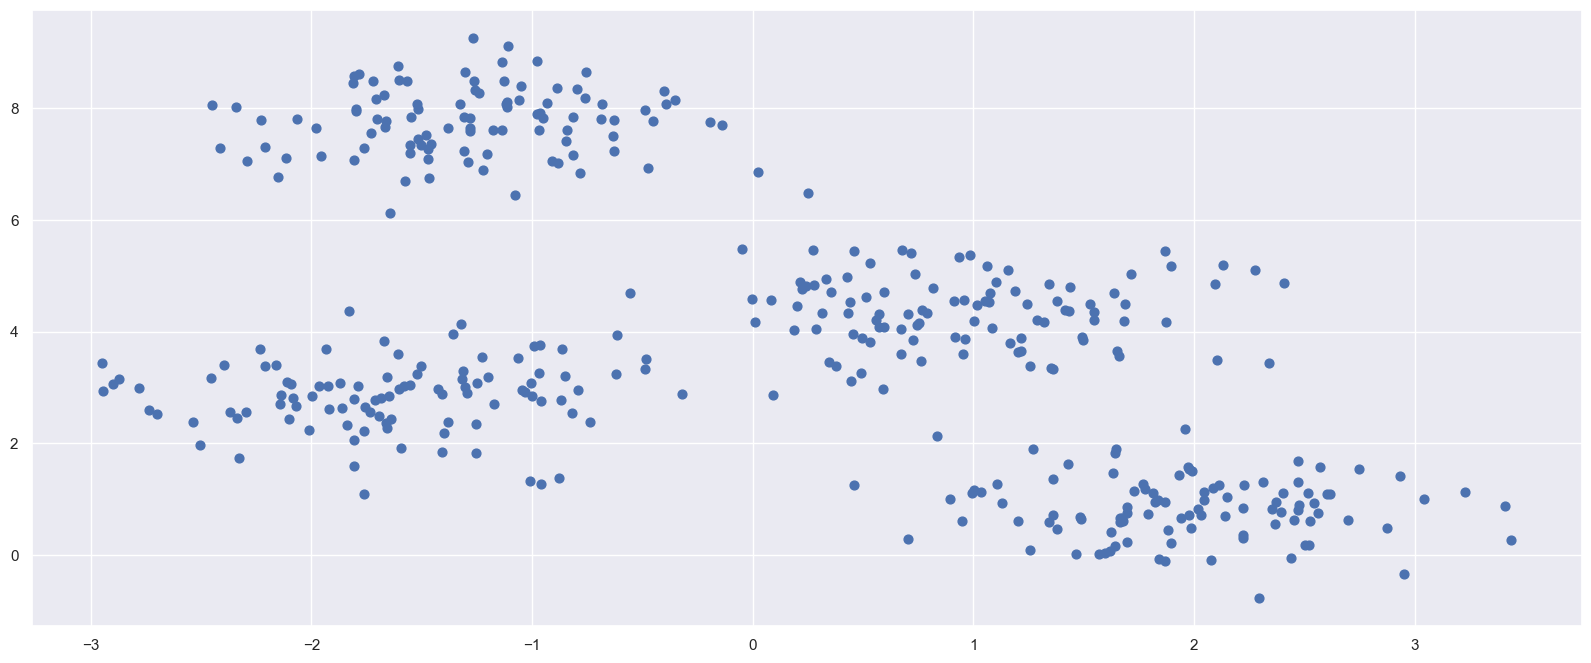

In [11]:
plt.scatter(X[:, 0], X[:, 1], s=40)

We can use GMM to cluster said blobs, just like with k-means.

C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


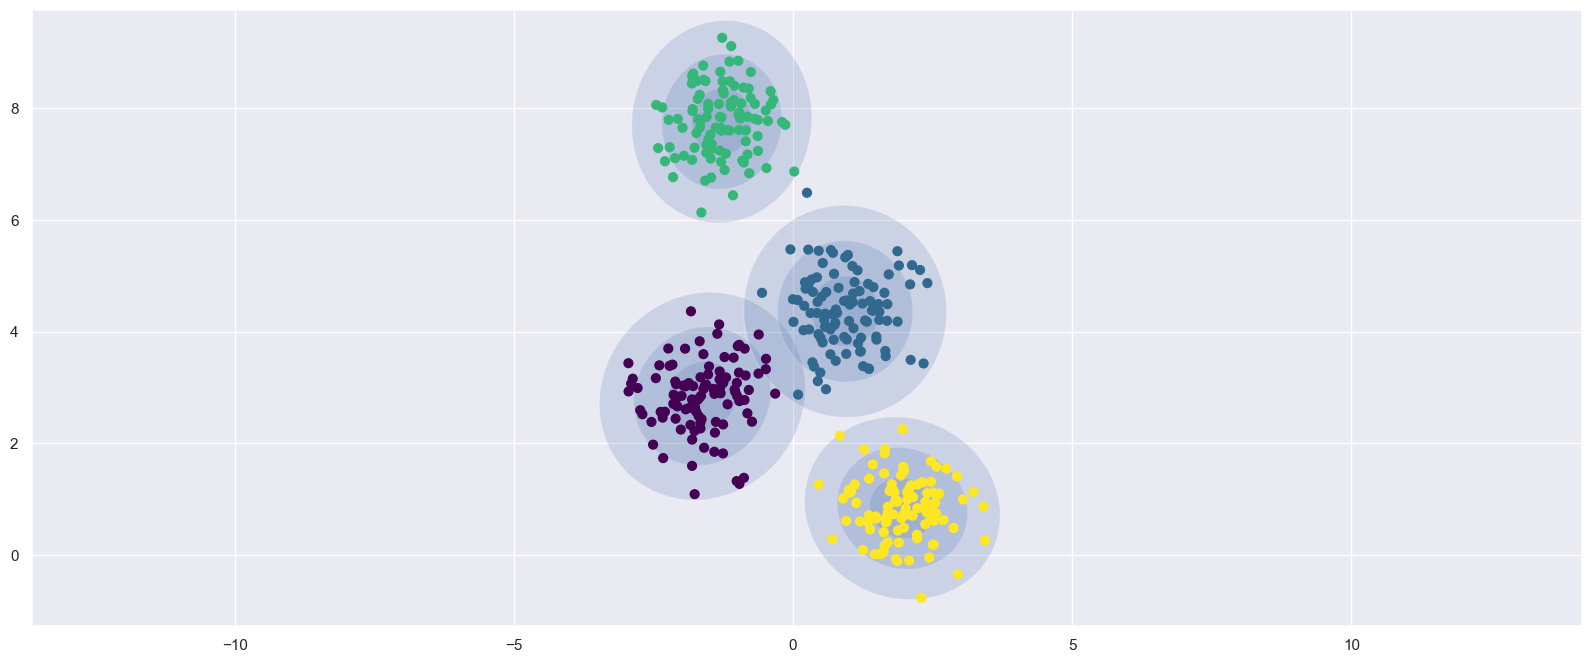

In [12]:
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
#plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
plot_gmm(gmm, X)

### AIC and BIC

We can plot number of clusters vs AIC and BIC to see which number of clusters is best. We want to minimize AIC and BIC, so we can see that 4 looks like a good number of clusters. These two will generally agree with each other.

C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\clust

Text(0.5, 0, 'n_components')

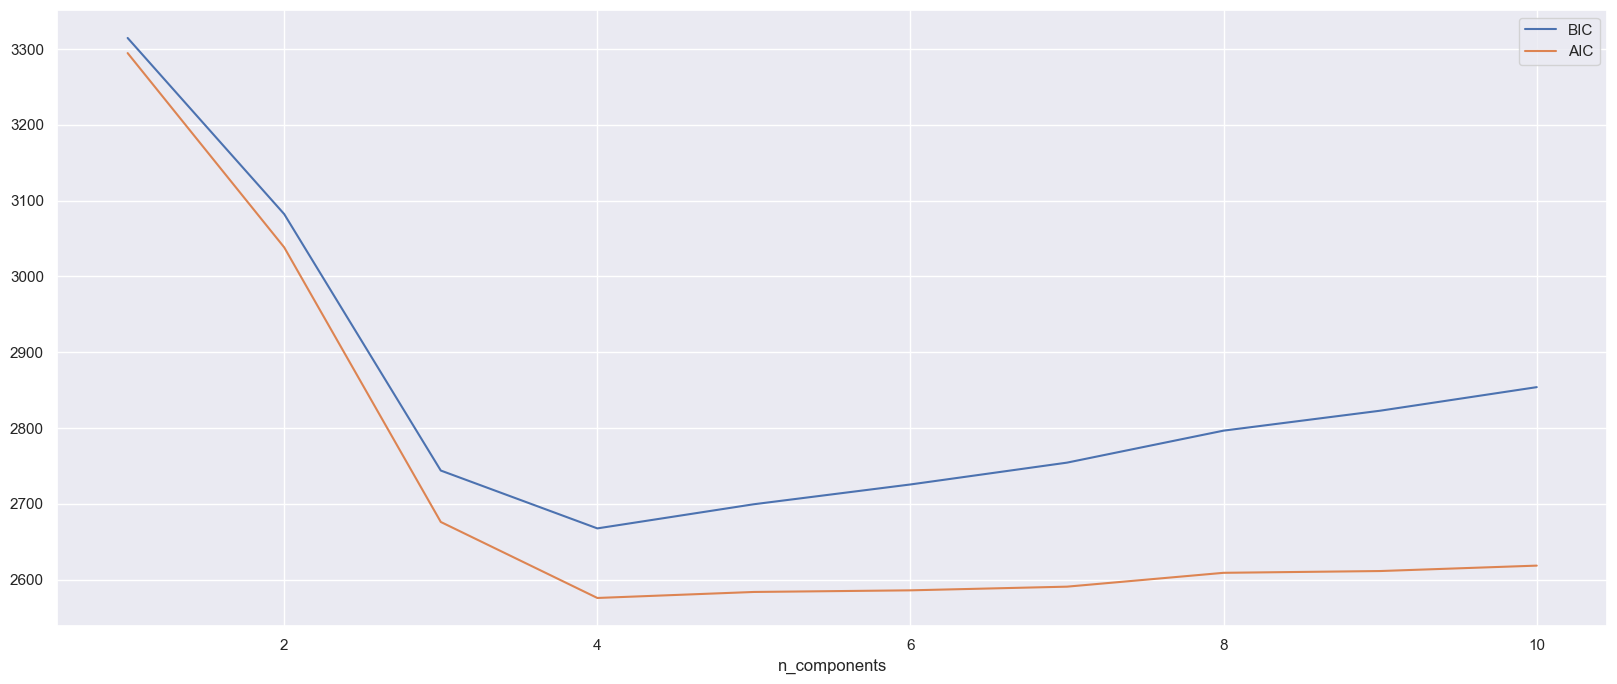

In [13]:
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

### Non-Spherical Clusters

Cool, but nothing new there. What if we have data that is not in nice circular-ish blobs, things that k-means doesn't capture well? The helper plotting function allows us to show the density - it is normally distributed. The middle dark parts are dense, and as it fans out, it gets less dense and lighter. 

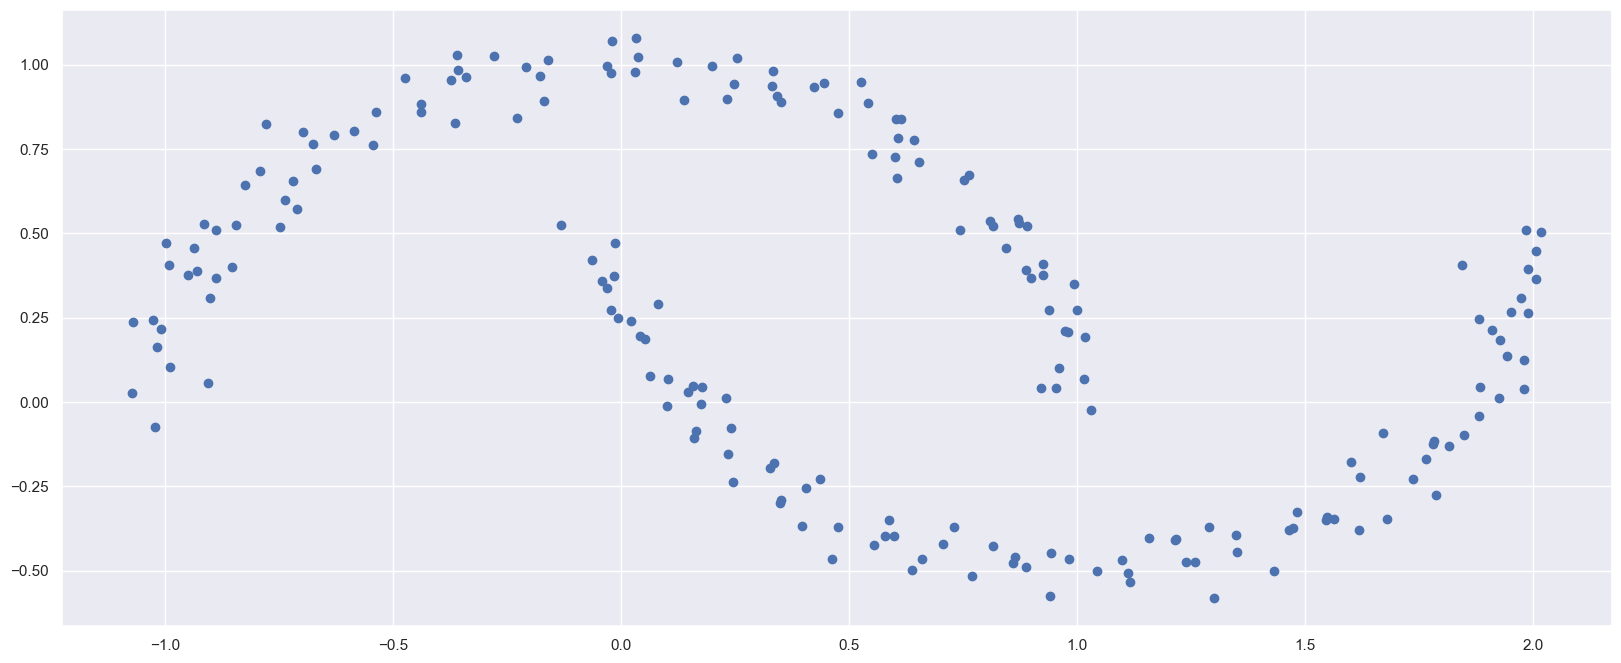

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

There are clearly 2 clusters here, but they are not circular - k-means will suck at clustering them and agglomerative may do well or poorly, depending on linkage. Try it and see. 

We can try GMM and see what we get. 

C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


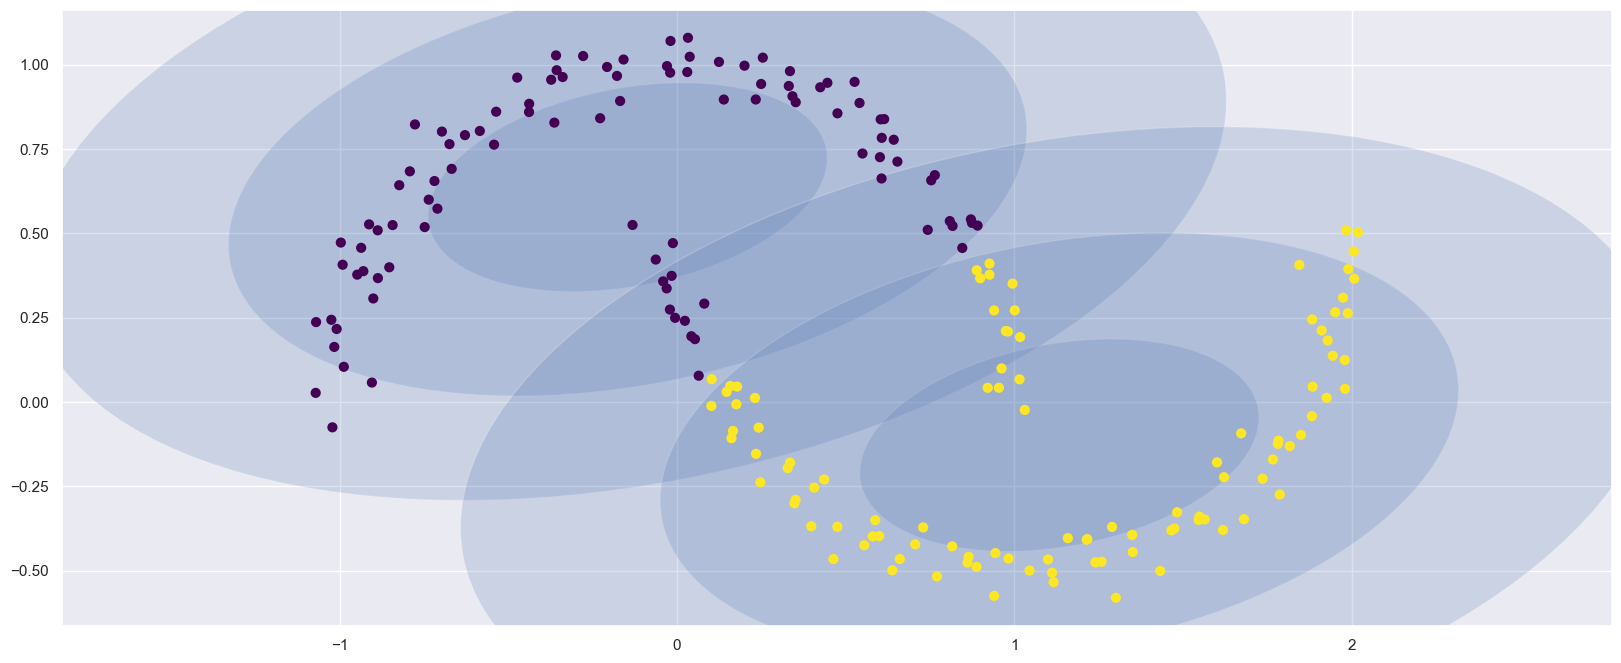

In [15]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Maybe better? But still not good, an ellipse doesn't really capture the data here either. What can we do?

What if we used several clusters, so there were a few "top curve" clusters, and a few "bottom curve" clusters and the entire distribution was all of them stiched together? This concept may be helpful later. 

C:\Users\Asdukey\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


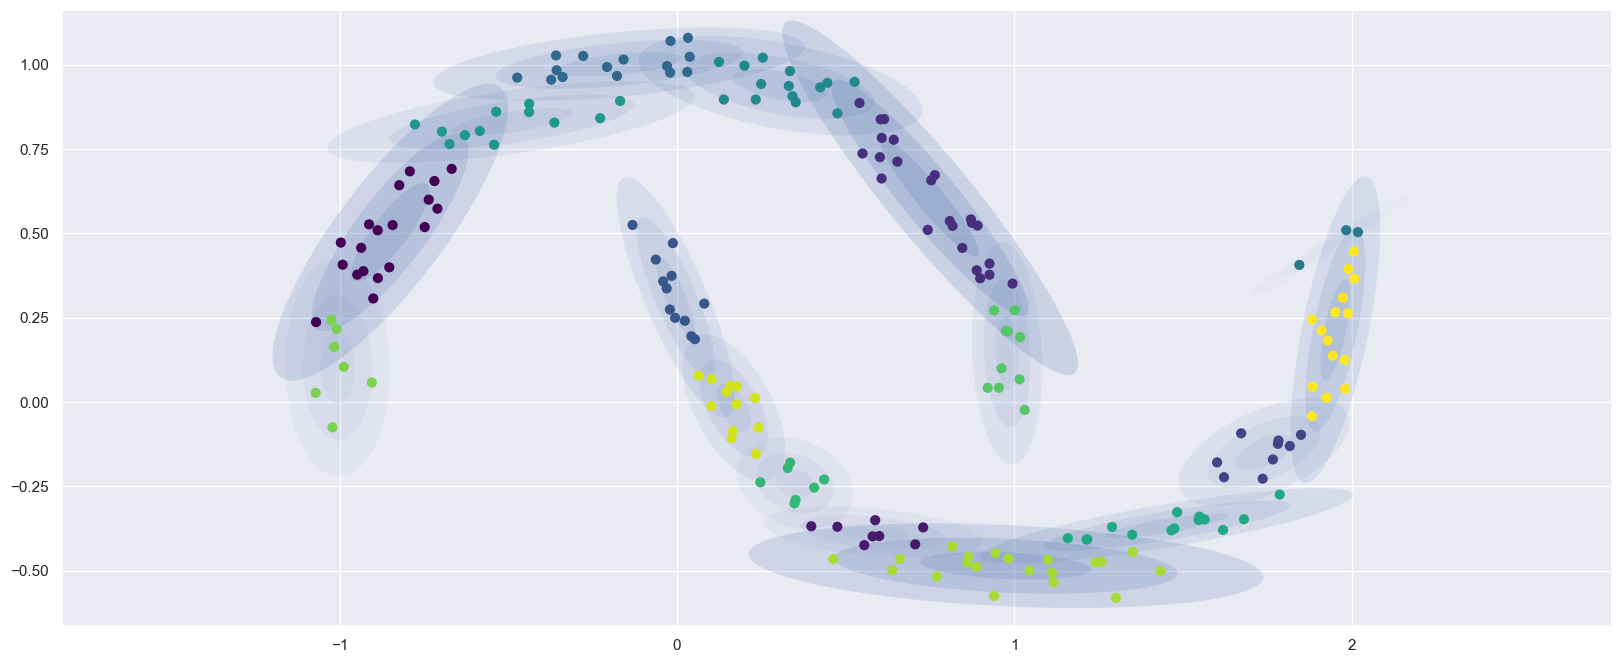

In [16]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon)

### GMM and Anomaly Detection

GMM can be applied to detect anomolies, similar to finding an outlier in a distribution. Anything "too far" towards the edge is an anomaly. This can be used in things like fraud detection - normal transactions cluster together, if there is something "weird" it will be different, farther out, and that is something that may need investigation. This works well for things where we don't necissarily know what the "normal" is, but we can find it by clustering. A bank knows some things that indicate potential fraud (i.e. large cash transactions), but they don't know everything. There are all kinds of transactions, large and small, of all types, every day, the vast majority of those being normal. As well, criminals are actively trying to avoid detection, so they'll change what they do constantly. We can't really define what a normal transaction is in the constantly changing sea of all the different transactions a bank sees, but we can use a clustering approach to try to draw it out. We can cluster all transactions based on all the data the bank has (i.e. time of day, amount, type, etc...) and then use the clusters to find the "normal" transactions. Things that are totally different from any of the transactions that are common (in the clusters) are worthy of a closer look - most are likey just infrequent things like someone financing a huge amount, but others may be fraud.

Anomaly detection is one simple and pretty direct application of clustering, especially if we have a lot of data. Clustering naturally groups things that are similar, even if we don't really understand the values defining that similarity, and for stuff like fraud or defect detection, that may do the job. 

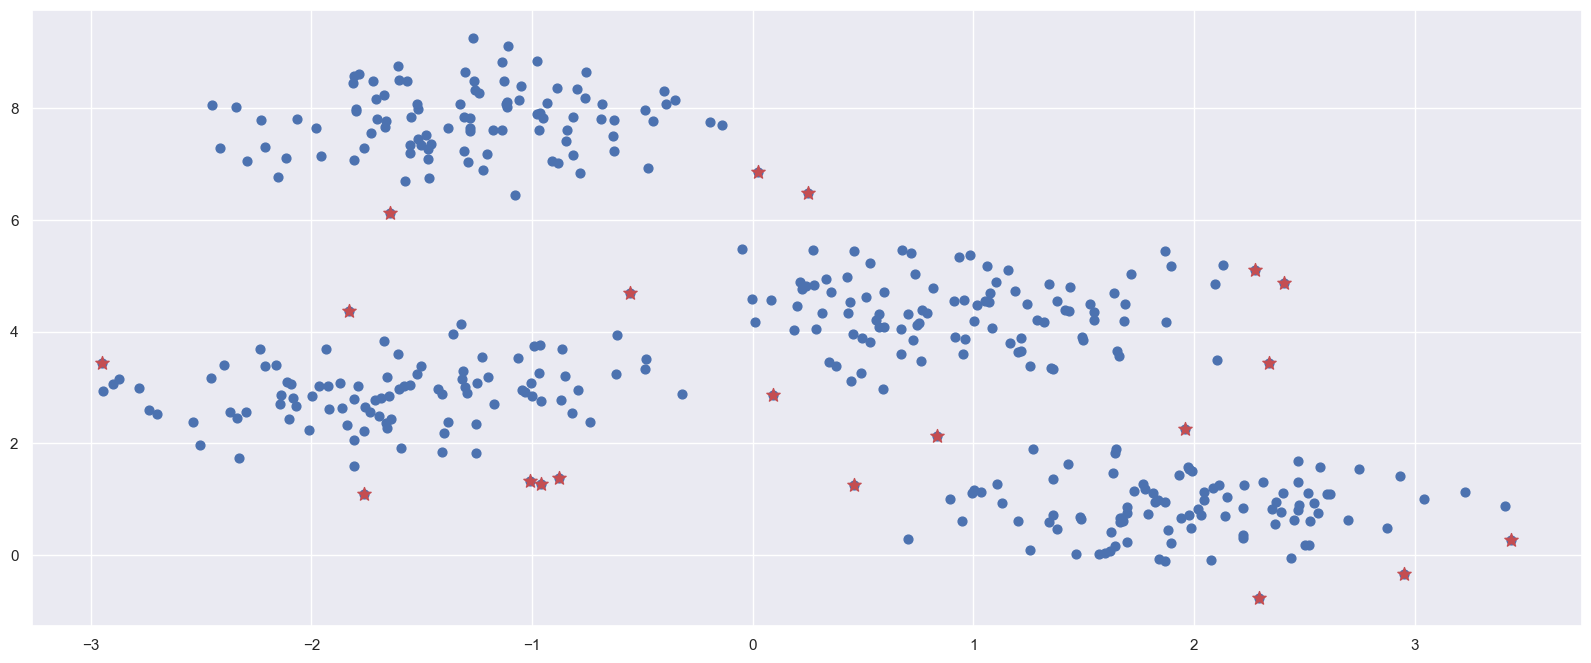

In [17]:
densities = gmm.score_samples(X)
density_threshold = np.percentile(densities, 5)
anomalies = X[densities < density_threshold]
plt.scatter(X[:, 0], X[:, 1], s=40)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*', s=100)

## GMM and Generative Models

One cool thing that we can do with GMM is can use them generatively, or to produce new data. We can generate moon-shaped new data from the distributions that we grabbed above. 

Here we have a gaussian distribution for each of our clusters that is held in our GMM object that was fitted to the data. These distributions basically define the expected location of the data - lots in the center of the distribution, few towards the edges. Just like we can sample from a regular distribution, we can sample from our GMM distributions. The result is new "fake" data, that fits in our original data's patterns of distribution. Fun!

In real machine learing applications this is similar to one way large training datasets are created for neural network training - Generative Adversarial Networks. This isn't using a GMM, but it is a similar concept - new training data is created from the original dataset. As an example, these faces are generated, not real:

![GAN](images/gan.png "GAN" )

Generative models have really hit their stride recently with things like ChatGPT and Stable Diffusion entering the public view. There is a large amount of variation in the details of how those models work, but this basic idea remains the same as we'll look at here. Our model learns about what that type of data is supposed to look like while we fit/train it, then we can ask the model to generate a new piece of that that it expects to fit, such as the next word in a sentence, or the next frame in a video.

#### Generate New Data

We can ask the model to make us some data, and it will generate new data that fits the distribution of the original data. <b>This data is not real, it just matches the patterns that we saw in the original data.<b>

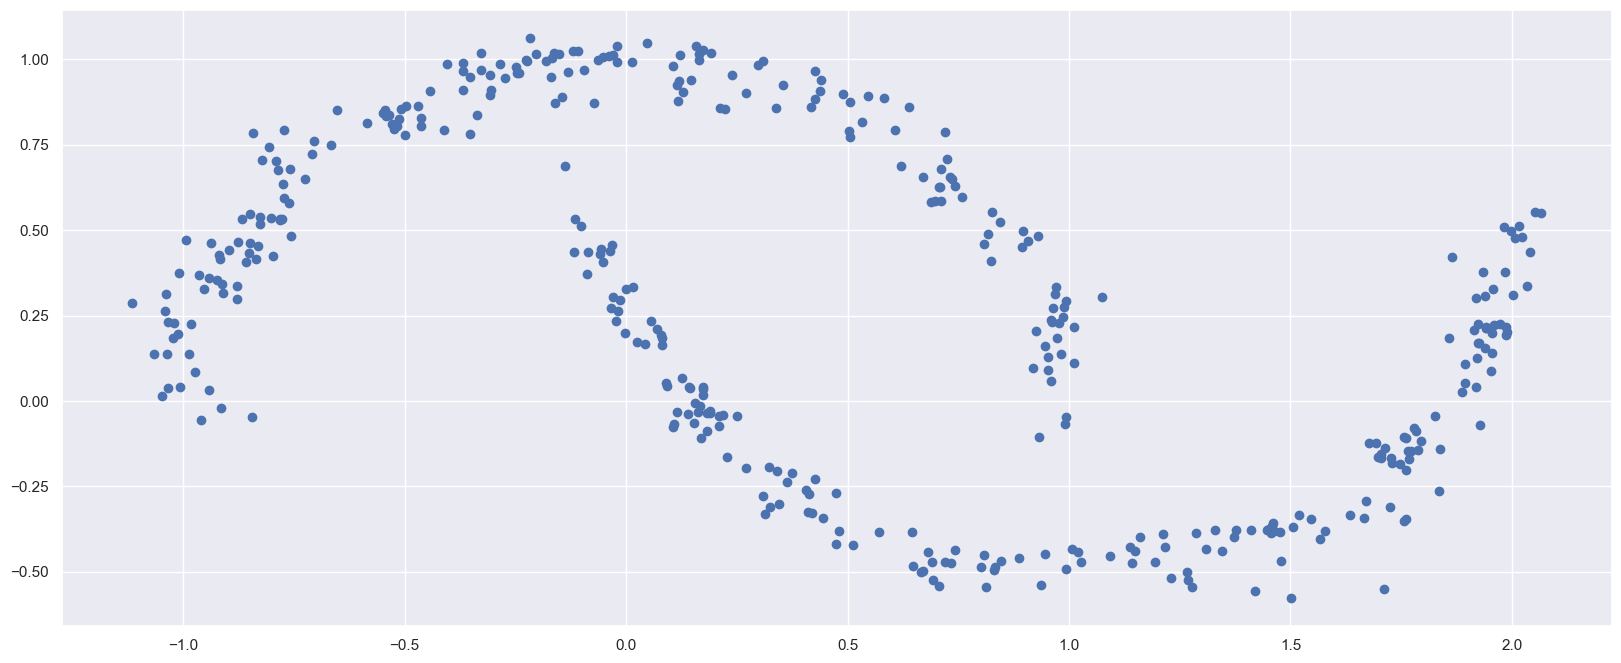

In [18]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1])

### Generating Images

Making random plots is cool, but we can leverage this to do much better things. For example, numbers that are handwritten follow a predictable pattern - can we learn it and write new fake digits? 

In [19]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
X, y = mnist["data"][0:15000], mnist["target"][0:15000]
print(X.shape)
print(y.shape)

(15000, 784)
(15000,)


We'll load some helper functions that we had from before, to display digits. 

In [20]:
#Look at an image
def showDigit(digit, label, size=28):
    some_digit = digit
    #turn array into the correct shape
    some_digit_image = np.array(some_digit).reshape(size, size)
    #imshow displays an array like an image
    plt.imshow(some_digit_image, cmap=mpl.cm.binary)
    plt.title(label)
    plt.axis("off")
    plt.show()

#Display multiple digits
def showDigits(digits, labels, indexes, size=28):
    #Make a grid that is the right size
    pics = len(indexes)
    cols = 6
    rows = math.ceil(pics/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(0, pics):
        n = indexes[i]
        some_digit = digits[n:n+1]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
        ax.set_title('Ind: {} - Lbl: {}'.format(indexes[i], labels[n]))
    plt.tight_layout()
    plt.axis("off")
    plt.show()

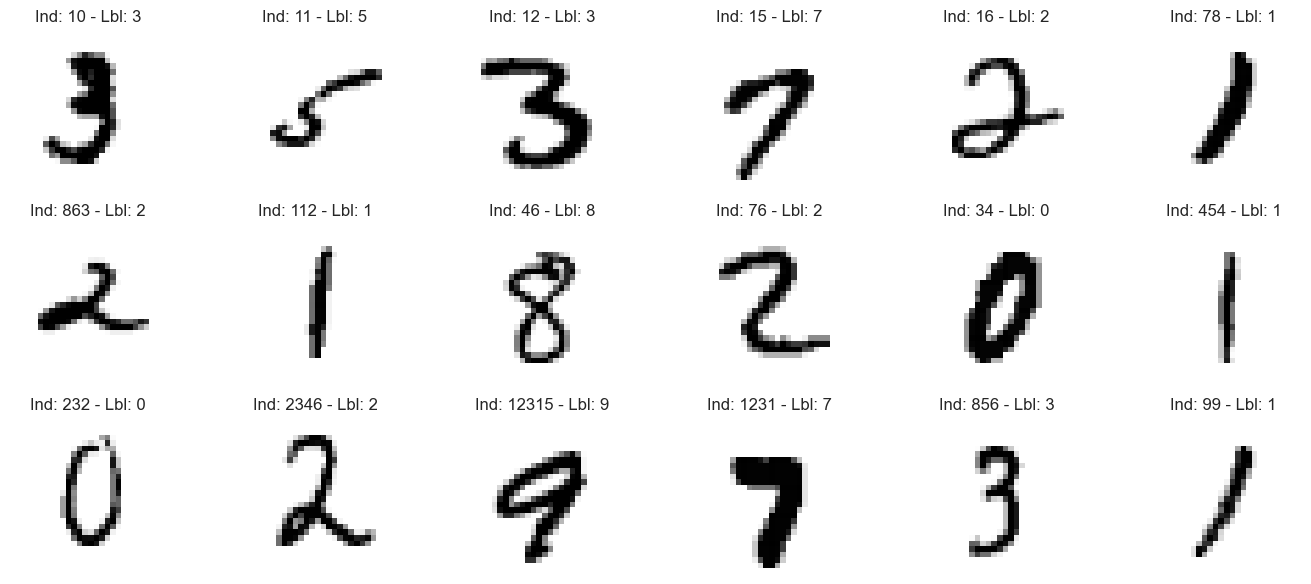

In [21]:
# Look at some digits
showDigits(X, y, [10,11,12,15,16,78,863,112,46,76,34,454,232, 2346, 12315,1231, 856, 99])

Yup, those are digits. 

#### PCA, GMM, and Data Generation

Now we "know" what each digit looks like, and we can get our model to use that knowledge to spit out some results. Since one of the things we noted of PCA is that it can reduce noise in the data, we will add a PCA step here:
<ul> 
<li> The whiten parameter is used to normalize the data in a built-in step. 
<li> The .99 parameter is used to tell PCA to keep 99% of the variance in the data.
</ul>

PCA will likely also help with speed, since the original data is high dimension. 

In [22]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(X)
data.shape

(15000, 328)

We are down to ~330 components, while preserving 99% of the variance. We can look at the AIC (commented out) to see what we should be picking. This can take a long time, feel free to tighen the range of the "arange" command to speed it up. 

We could also use another similar library - BayesianGaussianMixture, which can evaluate a good number of clusters for us. This will also be pretty slow with the large amount of data we have. 

In [23]:
#This is pretty slow

#n_components = np.arange(250, 350, 10)
#models = [GaussianMixture(n, covariance_type='full', random_state=0)
#          for n in n_components]
#aics = [model.fit(data).aic(data) for model in models]
#plt.plot(n_components, aics)

In [24]:
#from sklearn.mixture import BayesianGaussianMixture
#bgm = BayesianGaussianMixture(n_components=300)
#bgm.fit(X)
#print(bgm.converged_)
#print(np.round(bgm.weights_, 2))

##### Fit the Model

First we need to fit the GMM to the data, as normal. 

In [25]:
gmm = GaussianMixture(300, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


##### Generate Data

Once we have a model, it is simple to ask it to generate new data, we can use the .sample() function to tell it to give us N new samples. Importantly, this sample is not like a dataframe sample, where we are picking from a set, this is creating brand new data. We then use the inverse transform to get the data back into the original format, a bunch of pixels. Once that's done, this is like any other image. 

In [26]:
data_new = gmm.sample(10)
data_new = data_new[0]
data_new[0].shape

(328,)

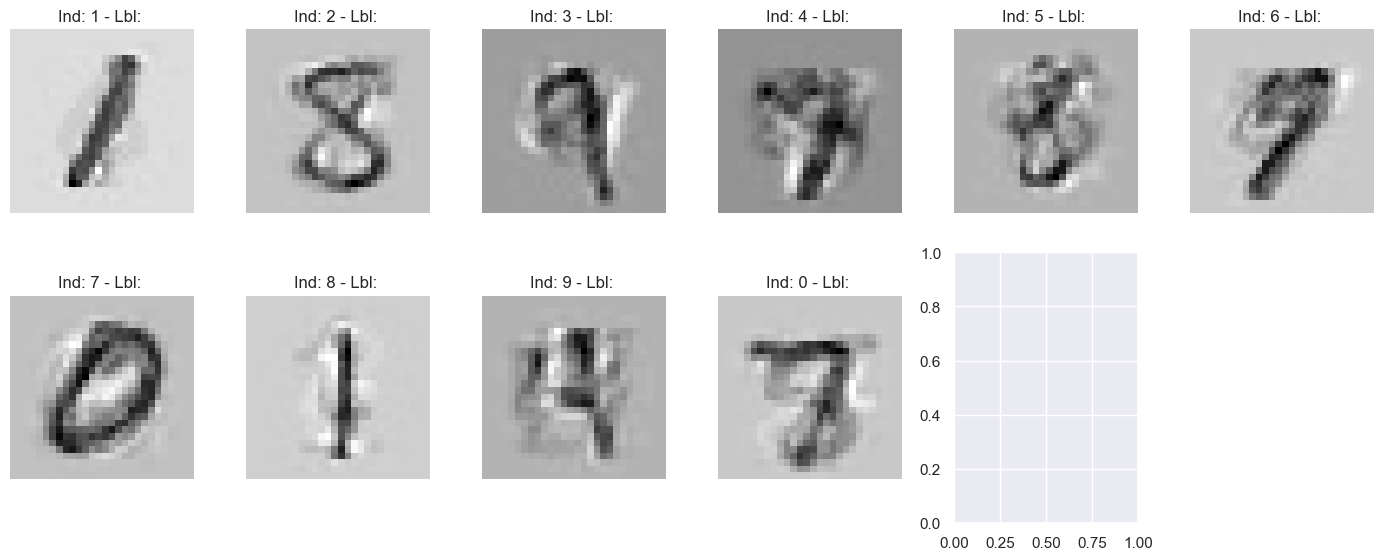

In [27]:
digits_new = pca.inverse_transform(data_new)
showDigits(digits=digits_new, labels=["","","","","","","","","",""], indexes=[1,2,3,4,5,6,7,8,9,0], size=28)

#### Results

Success! The above 

## k-Nearest Neighbors - kNN

k-Nearest Neighbors, or kNN, is a <b>supervised</b> machine learning algorithm that we can use for both regression and classification. This <b>is not</b> the same as k-means clustering nor is it directly related, it is conceptually similar though, so we'll take a quick peek at it here. We won't examine kNN in depth. 

The basic idea of kNN is that things that are similar are "close" to each other. The algorithm functions like this:

<ol>
<li> Select the number K of the neighbors
<li> Calculate the Euclidean distance of K number of neighbors
<li> Take the K nearest neighbors as per the calculated Euclidean distance.
<li> Among these k neighbors, count the number of the data points in each category.
<li> Assign the new data points to that category for which the number of the neighbor is maximum.
<li> Our model is ready.
</ol>

![kNN](images/knn.png "kNN" )

Implementation in sklearn is pretty similar to other modelss. 

kNN is relatively simple, but can get slow with large volumes of data and is often surpassed in performance by other models, so we don't see it used all that much. 

In [28]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

model_knn_class = KNeighborsClassifier()
model_knn_reg = KNeighborsRegressor()

## kNN Imputation

One place where kNN is very useful is in doing imputation. When we have done imputation, we've gone with something simple, like the mean or median, or the mode for the most frequent value. This is easy, but has some obvious weaknesses. Suppose we are imputing something like income for census type data. Taking the median income for a random missing income value may be OK, but people tend to have pretty different incomes. What if instead of just taking the overall average, we took the average of the nearest neighbors - in this case potentially, literal neighbors. 

KNNImputer is an imputation method that does just that, each record will "find its neighbors" based on similarity on the other metrics, and that subset of records will be averaged and imputed. In this example, we may impute by finding people with similar location, home size, career, etc... and taking their average, which makes more sense intuitively and can often be more accurate. Using this smarter imputation will often improve our ability to make useful imputations when data is missing, the exact impact depends on the data, but it is something that is certainly worth a try. 

![KNN Imputation](images/knnImpute.png "KNN Imputation" )

In the image above, if we were imputing a class, we would take the most common class of the nearest neighbors inside that "K" circle. For a number, we'd average those records together. Another sklearn package, IterativeImputer, does a similar thing using regression. See sklearn documentation for details, use is simple, just like other imputers.

A demo of smarter imputation can be seen easily in a really simple example. The values in the <b>top right</b> and the <b>first row, 2nd from bottom</b> are imputed differently with each imputer. 

In [29]:
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
nan = np.nan
X = [[1, 0, nan], [7, 4, 0], [nan, 8, 5], [9, 8, 7]]

<AxesSubplot:>

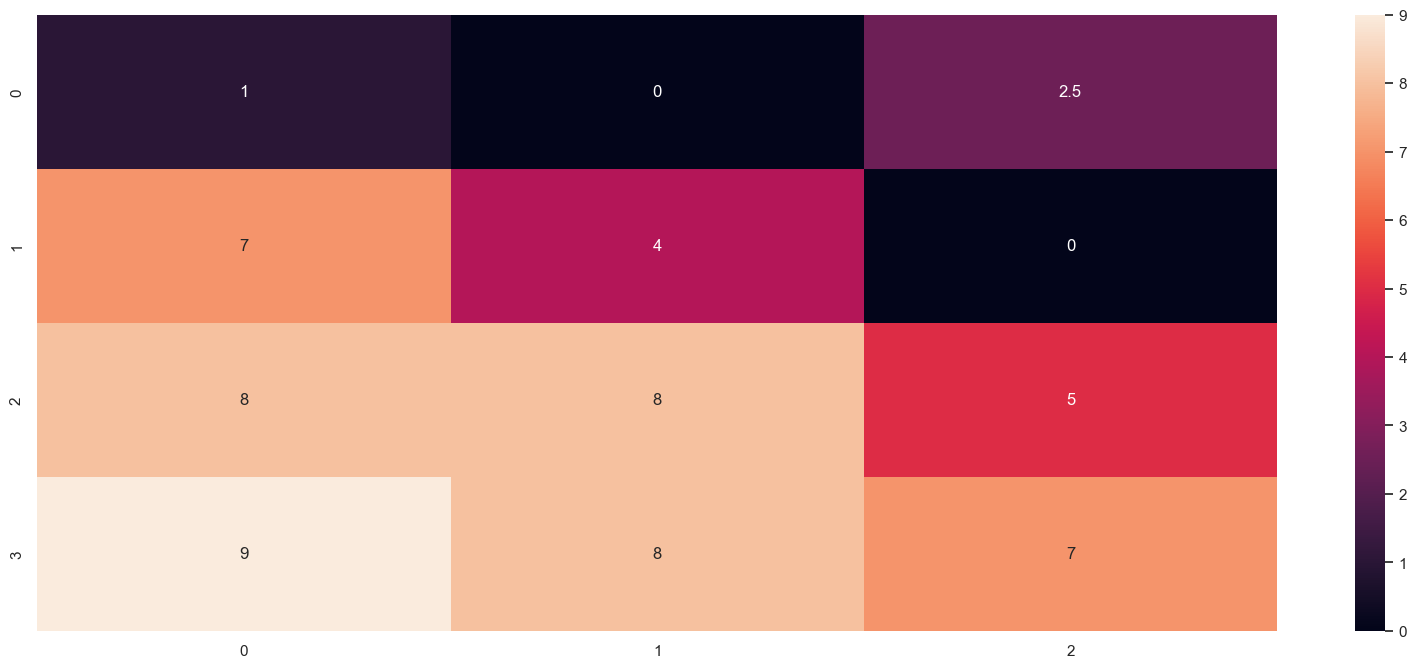

In [30]:
knn_imp = KNNImputer(n_neighbors=2, weights="uniform")
sns.heatmap(knn_imp.fit_transform(X), annot=True)

<AxesSubplot:>

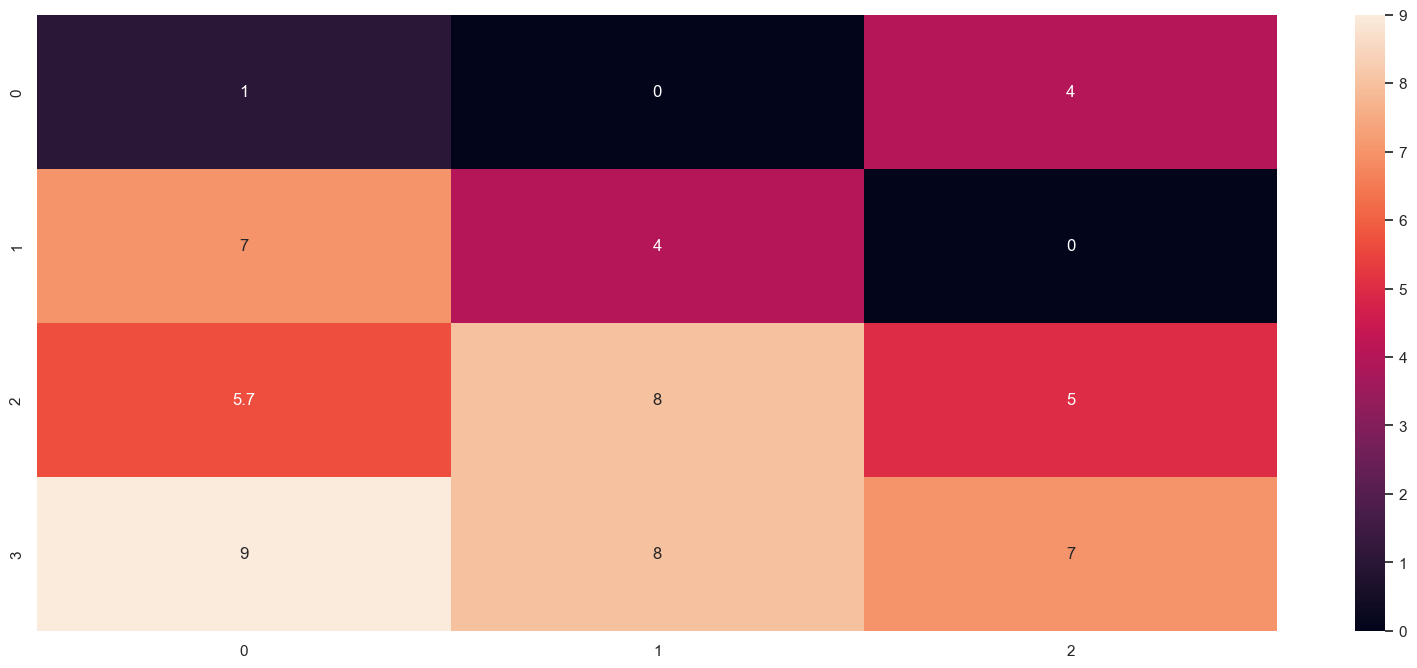

In [31]:
simp_imp = SimpleImputer()
sns.heatmap(simp_imp.fit_transform(X), annot=True)